# Introduction

Une kilonova correspond à l'entrée en coalescence de deux étoiles à neutrons (voire d'une étoile à neutron et d'un trou noir). Il s'agit d'un phénomène encore très peu observé ; la première obervation date de 2017. C'est donc un domaine bien moins connu que les supernovae.
Dans le cadre du projet 10 du cours de $\textit{Trous noirs, étoiles à neutron et phénnomènes associés}$,nous avons donc cherché à modéliser l'évolution au cours du temps d'une kilonova. 

Ce notebook rend compte de l'ensemble de notre travail sur notre projet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, exp
from scipy.integrate import odeint
import scipy.special as sc
%matplotlib inline

Il sera plus utile d'exprimer les durées en jour ou en années :

In [2]:
#Fonctions de conversion utiles
def s2day(t) :
    '''Conversion de t en seconde vers t en jours'''
    return t/(3600*24)

def s2year(t) :
    '''Conversion de t en seconde vers t en années'''
    return t/(3600*24*365)

#Conversion 1Mpc en m
D_MPc = 3.086e22 

# Partie Théorique

Les kilonovae ont un comportement qui peut se décomposer en deux grandes phases.

Dans la première phase, un éjecta, riche en éléments radioactifs est éjecté. Cet éjecta se propage librement. Dans la seconde phase, l'ejecta est freiné par le milieu environnant. 

Dans le cas des kilonovae, l’enrichissement en éléments lourds par le processus de capture rapide des
neutrons conduit à une opacité beaucoup plus élevée. Cette quantité de noyaux radiocatifs conduit à un terme de chauffage du aux désintegrations nucléaires. Pour les éléments lours, ceci résulte en une loi de puissance. Nous détaillerons cela plus tard.

Pour avoir un ordre de grandeur, notons déjà que pour l'éjecta d'une kilonova est caractérisée par une masse de l'ordre de $10^{-3}-10^{-1}$ masse solaire, pour une vitesse de $0.1-0.2c$ une opacité de 5 (élevée, conformement à ce que nous précision au paragraphe précédent) et un taille initiale très petite $10km$.

Nous introduisons donc si dessous l'ensemble des valeurs qui nous seront utiles. Nous utiliserons le système S.I. et figerons a priori les paramètre de l'éjecta. Les légendes des divers paramètres sont indiquées ci dessous:

In [3]:
#Constantes physiques
c = 3.e+8           #Vitesse de la lumière 
h = 6.626e-34       #Planck
kb = 1.380e-23      #Boltzmann
Jy = 10.e-26        #1 jansky en SI
sigma = 5.67e-8     #constante de Stefan
a = 4*sigma/c

#Constantes pour le soleil
M_sun = 1.989e+30
R_sun = 696340e+3
L_sun = 3.827e+26


#Paramètre pour le terme de chauffage
A = 6.6e+42/M_sun   
alpha = 1.3

In [4]:
#Constantes du problème
M_ej = 1.e-2*M_sun  #Masse éjectée
v_exp = 0.15*c      #Vitesse d'expension 
R_0 = 1.e+4         #Rayon initial
kappa = 0.5         #Opacité
D = 40*D_MPc

#Constantes du model 
k1 = 1.             #Ajustement du model pour temps radiatif 

n_ext=1.e6          #Densité du milieu extérieur
mu_ext=1
m_p=1.6726e-27
E_0= 1/2*M_ej*(v_exp)**2 #energie cinétique initale de l'éjecta

## Modèle à une zone

Pour l'ensemble de ce qui suivra nous considérerons que nous nous placerons dans un modèle à une zone: L'éjecta est considéré comme étant sphérique et homogène de rayon $R(t)$ et de masse volumique $\rho(t)=\frac{M_{ej}}{V(t)}$ avec $ V(t)=\frac{4\pi}{3} R^3(t)$. Ce milieu est isotherme de température $T(t)$. Comme dit précédemment, en étudiant les éjectas on peut mettre en évidence deux phases qu'on va détailler une par une.

### Phase initiale : expansion libre

Dans cette phase on consièdre que le freinage est négligeable. Conséquement l'expansion est à vitesse constante:
\begin{equation}
    R(t) = v_{exp} t
\end{equation}

avec $v_{exp}=cst$.
Ceci implique que l'énergie cinétique est constante. On peut alors écrire l'évolution de l'energie interne grâce au premier principe de la thermodynamique comme:
\begin{equation}
    \dfrac{dU}{dt}=- P \dfrac{dV}{dt}-L+ \dot{E}
\end{equation}

Dans cette équation, V est le volumme déjà donné dans le paragraphe précédent, P la préssion et L(t) la luminosité bolométrique. La quantité $\dot{E}$ correspond à la puissance radiative.

Comme indiqué dans le sujet on considère deux hypothèses supplémentaires: 

#### - la pression est dominée par la pression de rayonnement qui est donnée par :
\begin{equation}
P(t)\simeq \frac{1}{3} a T^4(t)
\end{equation}

Il vient alors que la densité d'énergie interne vaut $u=3P$ . On a alors:

\begin{equation}
U(t)\simeq \frac{4 \pi}{3} R^3(t) a T^4(t)
\end{equation}

Puis comme $u=3P$; il vient assez naturellement que 
\begin{equation}
-P(t)\dfrac{dV}{dt}\simeq -\frac{U}{3V} \dfrac{dV}{dt}\simeq -\frac{U}{3}\dfrac{d ln V}{dt}\simeq -U\dfrac{d ln R}{dt}\simeq -\frac{U}{t}
\end{equation}

On peut alors introduire tout naturellement le premier temps caractéristique $t_{dyn}$ temps caractéristique du refroidissement:
\begin{equation}
t_{dyn} \simeq \frac{R}{v_{exp}} \simeq t
\end{equation}

#### - l'ejecta est opaque
A
Cette hypothèse soutend que le libre parcours moyen $\bar{l}=\frac{1}{\rho \kappa}$ avec $\kappa$ l'opacité est très petit devant R.Dans ces condtions , le rayonnement L est celui d'un corps noir qui s'exprime alors:
\begin{equation}
L(t)=4\pi R^2(t) \sigma T^4_S(t)
\end{equation}

La simple application du transport radiatif à une zone relie alors la température interne $T$ et de surface $T_S$ par :
\begin{equation}
T_s(t)=(\frac{\bar{l}}{R})^{1/4} T(t)
\end{equation}

On peut alors relier L à T température interne par $L(t)\simeq 4 \pi R(t) \bar{l}(t) \sigma T^4(t)$. Se faisant on peut alors exprimer L en fonction de U par $L(t) \simeq \frac{U(t)}{t_{rad}(t)}$ où $t_{rad}$ est donné par :

\begin{equation}
t_{rad}\simeq \frac{R^2}{\bar{l}c} \simeq \frac{3M_{ej}\kappa}{4\pi c v_{exp}t}\simeq \frac{t_{*}^2}{t}
\end{equation}

L'expression de $t_*$ est asssez évidente. Le calcul de cette grandeur est donné dans la cellue 7 sous le nom de "t_star".

### Validité des hypothèses

Ce modèle s'est fait sous deux hypothèses. La première hypothèse est toujours largement vérifiée. De fait il suffit que :

\begin{equation}
\frac{\rho(r) k  T(r)}{\mu m_p} \ll \frac{1}{3} a T^4(t)
\end{equation}

La seconde est plus complexe, puisqu'il faut que $\bar{l} \ll R$ ceci est alors vrai tant que R est inférieur à un certain rayon $R\ll R_{neb}= (\frac{3M_{ej} \kappa }{4\pi})^{\frac{1}{2}}$. Cette relatin se déduit de l'expression de $t_{rad}$ .
Etant donné l'expansion constante de l'ejecta on peut alors introduire un troisième temps caractéristique: $t_{neb}=\frac{R_{neb}}{v_{exp}}$ soit $t_{neb}\simeq (\frac{3M_{ej} \kappa }{4\pi v^2_{exp}})^{\frac{1}{2}}$. En utiliant encore une fois l'expression de $t_{rad}$ on a très simplement $t_{neb}= \frac{t_{*}}{(v_{exp}/c)^{1/2}}$.

Nous introduisons dans la cellule ci dessous, les valeurs de $t_{*}$ "t_star", de $R_{neb}$ et de $t_{neb}$:

In [5]:
#Calcul des temps et longueurs caractéristiques
t_star = sqrt(3*M_ej*kappa/(4*pi*c*v_exp))
R_neb = sqrt(3*M_ej*kappa/(4*pi))
t_neb = R_neb/v_exp

print("Constantes caractéristiques du probleme :")
print("t* = " + str("%.2e"%t_star) + " s = " + str("%.2f"%s2day(t_star)) + " jours")
print("t_neb = " + str("%.2e"%t_neb) + " s = " + str("%.2f"%s2day(t_neb)) + " jours")
print("R_neb = " + str("%.2e"%R_neb) + " m = " + str("%.2f"%(R_neb/R_sun)) + " Rayons solaire")

Constantes caractéristiques du probleme :
t* = 4.19e+05 s = 4.85 jours
t_neb = 1.08e+06 s = 12.53 jours
R_neb = 4.87e+13 m = 69974.01 Rayons solaire


Nous pouvons dès lors remarquer une chose.

Nous avons $\frac{t_{neb}}{t_*}= (\frac{c}{v_{exp}})^{1/2}$. Par conséquent, pour des éjectas rapide de l'ordre de 0.2c, le rapport des deux temps est de l'ordre de $\sqrt{5}$. 

Ceci correspond bien à l'ordre de grandeur trouvé ci dessus.

In [6]:
#Rayon de la supernova qui est une fonction affine du temps 
def R(t) :
    return v_exp*t 

### Equation d'évolution de l'ejecta dans la phase d'expansion libre : 
Nous rappelons que nous avions 
\begin{equation}
    \dfrac{dU}{dt}=- P \dfrac{dV}{dt}-L+ \dot{E}
\end{equation}

Or nous avons vu que $L(t) \simeq \frac{U(t)}{t_{rad}(t)}$ et que $-P(t)\dfrac{dV}{dt}\simeq  -\frac{U}{t}$. On a alors:  

\begin{equation}
    \dfrac{d t_{rad} L}{dt}=-\frac{U}{t}-L+ \dot{E}\\
    t_{rad}\dfrac{d  L}{dt}+L\dfrac{d t_{rad}}{dt} =-\frac{t_{rad} }{t}L-L+ \dot{E}\\
    t_{rad}\dfrac{d  L}{dt}-L\dfrac{t_{rad}}{t} =-\frac{t_{rad} }{t}L-L+ \dot{E}
\end{equation}

Il vient alors que l'équation finale est :
\begin{equation}
t_{rad}\frac{dL}{dt} + L(t) = \dot E(t)
\end{equation}

Si on a l'expression de $\dot{E}$, le calcul de L sera trivial. Dans le cas des kilonovae, on a que le terme de chauffage suit une loi de puissance en t de la forme: 
\begin{equation}
    \dot{E} \simeq A M_{ej} t^{- \alpha} \quad avec \quad \alpha\simeq 1.3
\end{equation}

A est un terme de chauffage constant.
En utilisant alors odeint on peut alors calculer la luminisoté $L(t)$

Pour cela, on utilisera le solveur d'équation différentielles $\texttt{odeint}$ de la librairie $\texttt{scipy}$

In [7]:
#Dérivée temporelle de l'énergie interne que l'on utilise dans le modèle suivant
def E_dot(t) :
    return A*M_ej*pow(t,-alpha)


#Equation différentielle à résoudre avec odeint
def model(L,t) :
    dLdt = (E_dot(t)-L)*k1*t/pow(t_star,2)
    return dLdt


#Integration de l'équation différentiel pour L(t) sur t dans [0, 1.3*t_neb]
t_list = np.linspace(1.e-6, 1.3*int(t_neb), num=10000)
L0 = 0
L = odeint(model, L0, t_list)

In [8]:
#Libre parcours moyen des photons en fonction du temps
def l_bar(t) :
    rho = 3*M_ej/(4*pi*pow(R(t),3))
    return 1/(rho*kappa)

#T_list est la liste de la température interne sur un maillage temporel t_list
def T_list(t_list) :
    res = []
    for i in range(len(t_list)) :
        t = t_list[i]
        L_t = L[i]
        T_t = pow(L_t/(4*pi*R(t)*sigma*l_bar(t)),1/4)
        res+= [T_t]
    return res
        
#Ts_list est la liste de la température de surface sur un maillage temporel t_list
def Ts_list(t_list) :
    res=[]
    T = T_list(t_list)
    for i in range(len(t_list)) :
        t = t_list[i]
        T_t = T[i]
        Ts_t = pow(l_bar(t)/R(t),1/4)*T_t
        res+= [Ts_t]
    return res

#P_list est la liste de la pression sur un maillage temporel t_list
def P_rad_list(t_list) :
    T = T_list(t_list)
    return [a*pow(t,4)/3 for t in T]

def P_gaz_list(t_list) :
    P_gaz_list = []
    T = T_list(t_list)
    for i in range(len(t_list)) :
        t = t_list[i]
        Temp = T[i]
        rho = 3*M_ej/(4*pi*pow(R(t),3))
        P_gaz = rho*kb*Temp/0.5   #le 0.5 vient du mu*mp de l'Hydrogène
        P_gaz_list += [P_gaz]
    return P_gaz_list

#U_list est la liste de l'énergie interne sur un maillage temporel t_list
def U_list(t_list) : 
    T = T_list(t_list)
    res = []
    for i in range(len(T)) :
        t = t_list[i]
        Temp = T[i]
        res += [4*pi*pow(R(t),3)*a*pow(Temp,4)/3]
    return res

T = T_list(t_list)
Ts = Ts_list(t_list)
P_rad = P_rad_list(t_list)
P_gaz = P_gaz_list(t_list)
U = U_list(t_list)

In [9]:
#Expression de l'intensité spécifique (dans un modèle de corps noir)
def B_list(nu,Ts_arg_list):
    res = []
    for i in range(len(Ts_arg_list)):
        Ts_arg = Ts_arg_list[i]
        Bnu = (2*h*pow(nu,3)/pow(c,2)) / (np.exp((h*nu)/(kb*Ts_arg)) - 1)
        res += [Bnu]
    return res

$\textbf{Comportement asymptotique}$

Pour tracer completement la courbe de la luminosité nous nous intéressons au comportement asymptotique.
En réécrivant l'équation différentielle en $L$ sous la forme: $\dfrac{t_{rad}}{t}\dfrac{d ln L}{d ln t}= \dfrac{\dot{E}-L}{L}$. 

On voit alors que pour des temps longs (dans la mesure toutefois où $t \ll t_{neb}$) le facteur $\dfrac{t_{rad}}{t}\simeq \dfrac{t_*}{t}^2 \longrightarrow 0$ la luminosité étant naturellement bornée, il vient que le terme de gauche tend vers 0. De sorte que  $L \simeq \dot{E}$.

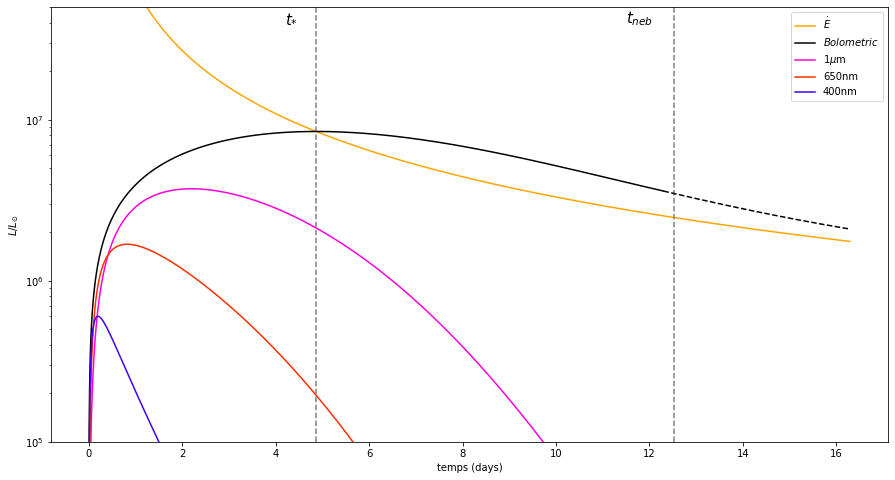

In [10]:
#Représentation grphique de L bolométrique ainsi que L pour différentes longueurs d'ondes

Nlim = 7550 #Utile pour tracer en pointillés après t_neb

plt.figure(figsize=[15,8])
plt.yscale('log')
plt.ylim(1.e5,5.e7)
plt.xlabel('temps (days)')
plt.ylabel('$L/L_{\odot}$')

#Plot de E point
plt.plot(s2day(t_list), E_dot(t_list)/L_sun, color='orange', label='$\dot{E}$')
#Ajout des lignes pointillées pour t_star et t_neb
plt.axvline(x=s2day(t_star),color='gray',linestyle='--')
plt.axvline(x=s2day(t_neb),color='gray',linestyle='--')
#Ajout legende pour t_star et t_neb
plt.text(int(s2day(t_star))+0.2,4.e7,'$t_{*}$',fontsize=15)
plt.text(int(s2day(t_neb)) -0.5,4.e7,'$t_{neb}$',fontsize=15)

#Plot Luminosité bolométrique
plt.plot(s2day(t_list[:Nlim]),L[:Nlim]/L_sun,color='black', label='$Bolometric$')
plt.plot(s2day(t_list[Nlim:]),L[Nlim:]/L_sun,linestyle='--',color='black')

#Plot Luminosité Spécifiques
lambda_Lspecifique = [1000.e-9, 650.e-9, 400.e-9]
color_Lspecifique = ['#FF00DC', '#FF2D00', '#3E00FF']
label_Lspecifique = ['1$\mu$m', '650nm', '400nm']
for i in range (len(lambda_Lspecifique)) :
    lambd = lambda_Lspecifique[i]
    nu = c/lambd
    Bnu = np.array(B_list(nu,Ts[1:]))
    L_specifique = np.array([4*pow(pi,2)*pow(R(t_list[k+1]),2)*Bnu[k] for k in range(len(t_list)-1)])
    plt.plot(s2day(t_list[:Nlim]),nu*L_specifique[:Nlim]/L_sun,color=color_Lspecifique[i], label = label_Lspecifique[i])
    
plt.legend(loc="upper right")


Sur la figure ci dessus on a représenté en noir la Luminosité bolométrique en échelle logarithmique. La courbe en jaune correspond, elle, à l'évolution de $\dot{E}$. On remarque alors plusieurs choses

- On voit que entre $t_{*}$ et $t_{neb}$, l'approximation $L = \dot{E}$ est bonne
- Les ordres de grandeurs, que ce soit pour les temps caractéristiques ou bien pour les valeurs de luminosité bolométrique sont bien conformes à celles données dans le sujet

On a aussi tracé pour 3 longueur d'ondes (ou fréquence $\nu$) différentes la quantité $\nu L_{\nu}$ où $L_{\nu}$ est la luminosité spécifique. On retrouve ici aussi des courbes conformes à celles données dans le sujet

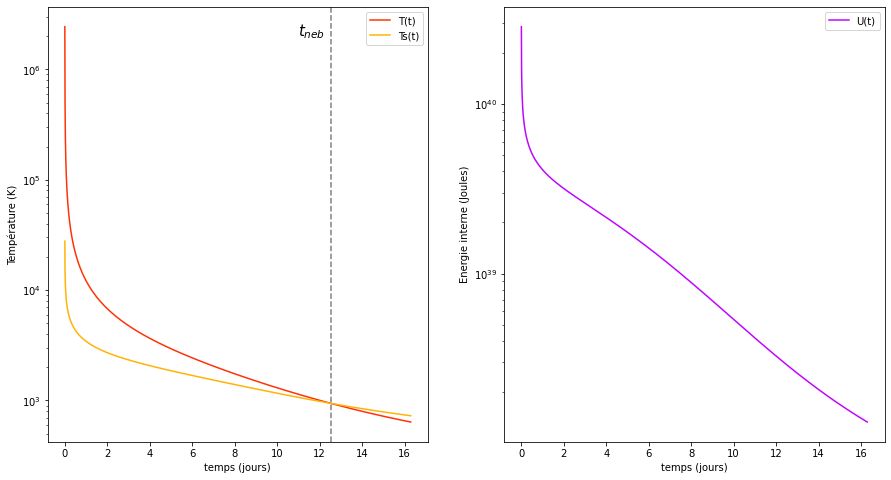

In [11]:
plt.figure(figsize=[15,8])

#Plot de la température 
plt.subplot(121)
plt.xlabel("temps (jours)")
plt.ylabel("Température (K)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),T[1:],label='T(t)', color ='#FF3105')
plt.plot(s2day(t_list[1:]),Ts[1:],label='Ts(t)', color='#FFB305')
plt.legend()
plt.axvline(x=s2day(t_neb),color='gray',linestyle='--')
plt.text(int(s2day(t_neb)) -1,2.e6,'$t_{neb}$',fontsize=15)

#Plot de l'énergie interne
plt.subplot(122)
plt.xlabel("temps (jours)")
plt.ylabel("Energie interne (Joules)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),U[1:],label='U(t)',color='#BF05FF')
plt.legend()



Sur les figures précédentes nous avons tracé les températures internes et de surface d'une part et l'énergie d'autre part. Nous remarquons que $T(t_{neb}) = T_i(t_{neb})$ 

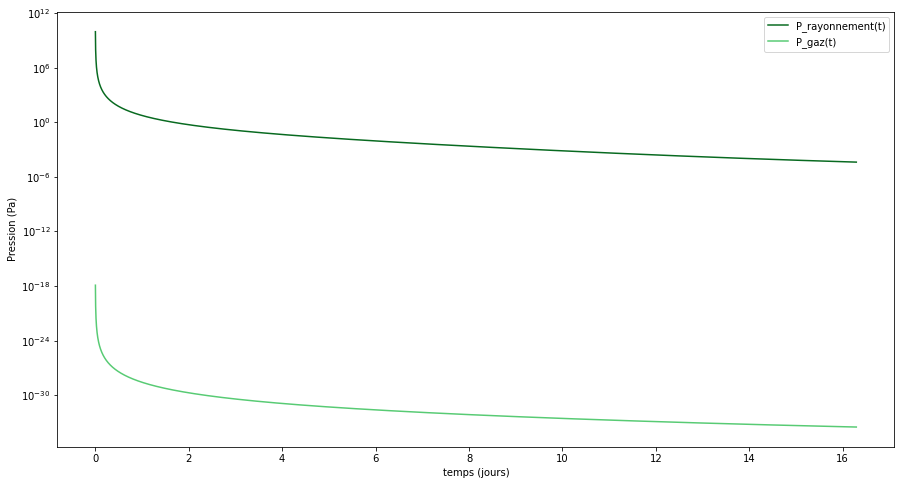

In [12]:
plt.figure(figsize=[15,8])

#Plot des Pression de radiation et 
plt.xlabel("temps (jours)")
plt.ylabel("Pression (Pa)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),P_rad[1:],label='P_rayonnement(t)',color='#086A20')
plt.plot(s2day(t_list[1:]),P_gaz[1:],label='P_gaz(t)',color='#58CB74')
plt.legend()

La figure précédente montre très clairement que l'hypothèse "la pression est dominée par la pression de radiation" est vérifiée. En effet, 30 ordres de grandeur séparent la presssion de radiation et la pression du gaz.

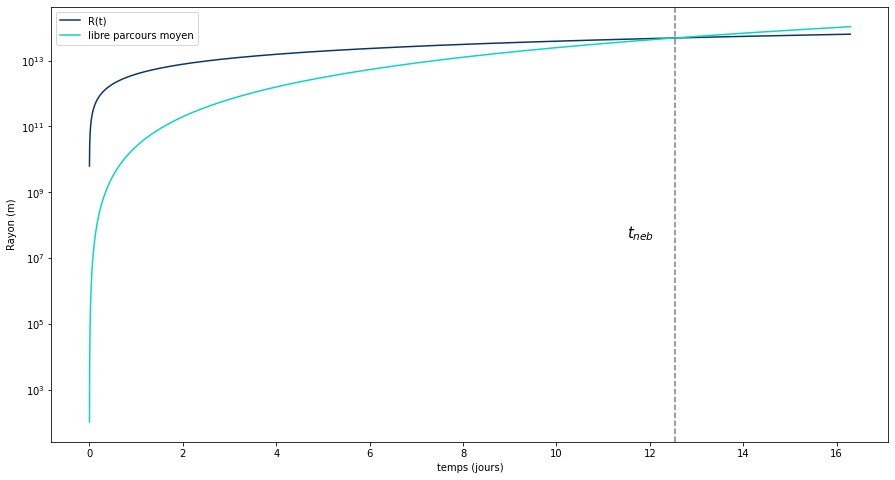

In [13]:
plt.figure(figsize=[15,8])

#Plot du rayon et du libre parcours moyen 
plt.xlabel("temps (jours)")
plt.ylabel("Rayon (m)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),[R(t) for t in t_list[1:]],label='R(t)',color='#08366A')
plt.plot(s2day(t_list[1:]),[l_bar(t) for t in t_list[1:]],label='libre parcours moyen',color='#0AD5C6')
plt.text(int(s2day(t_neb)) -0.5,4.e7,'$t_{neb}$',fontsize=15)

plt.axvline(x=s2day(t_neb),color='gray',linestyle='--')
plt.legend()

Sur la figure précédente, nous avons tracé l'évolution du rayon de la kilonova et du libre parcours moyen. Ainsi, on obtient $\bar{l}(t) > R(t)$ pour $t > t_{neb}$. Cela traduit bien le fait qu'à $t_{neb}$, l'éjectat devient transparent.

<ipython-input-9-d1cf3ef6db87>:6: RuntimeWarning: divide by zero encountered in true_divide
  Bnu = (2*h*pow(nu,3)/pow(c,2)) / (np.exp((h*nu)/(kb*Ts_arg)) - 1)
<ipython-input-14-ccdcbdc3d69b>:17: RuntimeWarning: divide by zero encountered in log
  magAB = [-2.5*np.log( pi*Bnu[i]*pow((R(t_list[i])/D),2)/(3631*Jy) )/np.log(10) for i in range(len(Bnu))]
<ipython-input-9-d1cf3ef6db87>:6: RuntimeWarning: divide by zero encountered in true_divide
  Bnu = (2*h*pow(nu,3)/pow(c,2)) / (np.exp((h*nu)/(kb*Ts_arg)) - 1)
<ipython-input-14-ccdcbdc3d69b>:17: RuntimeWarning: divide by zero encountered in log
  magAB = [-2.5*np.log( pi*Bnu[i]*pow((R(t_list[i])/D),2)/(3631*Jy) )/np.log(10) for i in range(len(Bnu))]
<ipython-input-9-d1cf3ef6db87>:6: RuntimeWarning: divide by zero encountered in true_divide
  Bnu = (2*h*pow(nu,3)/pow(c,2)) / (np.exp((h*nu)/(kb*Ts_arg)) - 1)
<ipython-input-14-ccdcbdc3d69b>:17: RuntimeWarning: divide by zero encountered in log
  magAB = [-2.5*np.log( pi*Bnu[i]*pow((R(t_list[

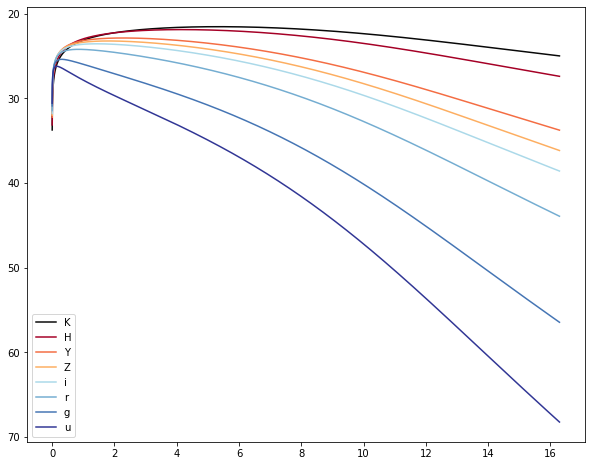

In [14]:
#Longueurs d'ondes et légendes correspondantes
lambd = [2190e-9,1630e-9,1020e-9,900e-9,806e-9,658e-9,464e-9,365e-9]

lettres = ['K','H','Y','Z','i','r','g','u']
colors = [ [8/255,8/255,8/255], [165/255,0/255,38/255], [244/255,109/255,67/255], [253/255,174/255,97/255], [171/255,217/255,233/255], [116/255,173/255,209/255], [69/255,117/255,180/255], [49/255,54/255,149/255] ]


plt.figure(figsize=[10,8])

for i in range(len(lambd)):

    #Intensité spécifique
    nu = c/lambd[i]
    Bnu = B_list(nu,Ts)

    #Conversion en jansky et en magnitude AB
    magAB = [-2.5*np.log( pi*Bnu[i]*pow((R(t_list[i])/D),2)/(3631*Jy) )/np.log(10) for i in range(len(Bnu))]

    plt.plot(s2day(t_list[1:]),magAB[1:],label=lettres[i], color=colors[i])

plt.gca().invert_yaxis()
plt.legend()

## Phase tardive: freinage et formation d'un reste

On peut montrer que la phase d'expansion libre se produit tant que $R \ll R_{dec}$ avec $R_{dec}=t_{dec}v_{exp}$ et 
$t_{dec}\simeq \left(\frac{3M_{ej} }{4\pi \rho_{ext} v^3_{exp}}\right)^{\frac{1}{3}}$. Pendant cette phase le freinage peut être considéré comme négligeable. On calcule ci dessous le temps de décéleration :

In [15]:
rho_ext= n_ext*mu_ext*m_p
t_dec = pow((3*M_ej/(4*pi*rho_ext*pow(v_exp,3))),1/3)
R_dec= t_dec*v_exp

print("t_dec = " + str("%.2e"%t_dec) + "  = " + str("%.2f"%s2year(t_dec)) + " années")

t_dec = 3.15e+08  = 9.98 années


### Phase de Sedov: restes jeunes

Lorsque la décélération commence, l'évolution, dans notre modèle à une zone se comporte de la manière suivante. On définit :

In [16]:
def R_sedov (t):
    return 1.152*pow((E_0*pow(t,2))/(rho_ext),1/5)

t_list2=np.linspace(1/2* int(t_dec), 10*int(t_dec), num=10000)

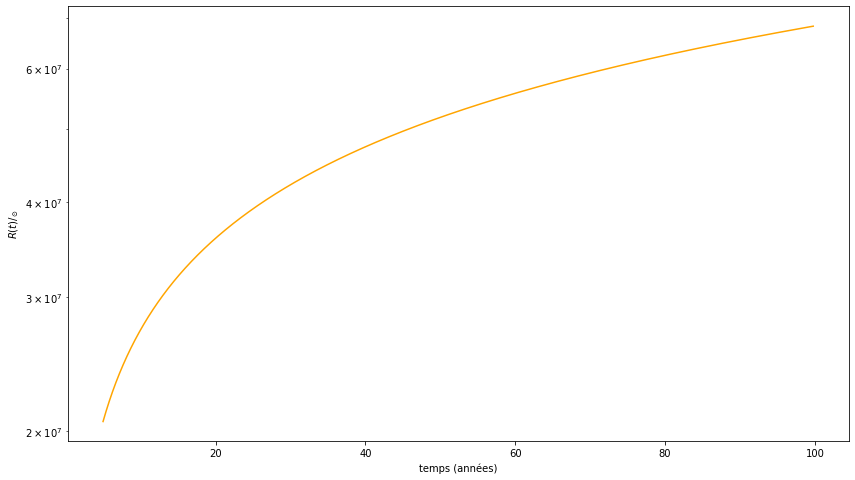

In [17]:
plt.figure(figsize=[14,8])
plt.yscale('log')

plt.xlabel('temps (années)')
plt.ylabel('$R(t)/_{\odot}$')
plt.plot(s2year(t_list2), R_sedov(t_list2)/R_sun, color='orange', label='$R(t)/R_{\odot}$')

In [18]:
def V_sedov(t):
    return 0.461*pow((E_0/(rho_ext*pow(t,3))),1/5)

### Phase radiative: restes âgés

Les équations trouvées ci dessus sont valable tant que les pertes radiatives sont faibles. On a supposé de fait une solution adiabatique. Pour $t \rightarrow +\infty$ cette hypothèse est naturellement fausse. Nous ne pouvons donc plus considérer l'énergie comme conservée. La quantité de mouvement , cependant, l'est toujours. En notans alors que $R^3 V= const$ et en notant $t_{transi}$ l'instant de la transition on a alors l'équation suivante:
    \begin{equation}
        R^3(t)V(t)= R^3(t) \dot{R}(t)  \simeq R^3_{sedov}(t_{transi})V_{sedov}(t_{transi})
    \end{equation}

Ce qui donne en intégrant: 
\begin{equation}
    R(t)\simeq \left( \dfrac{3}{5} \right)^{\frac{1}{4}} R_{sedov}(t_{transi})\left(1+\dfrac{2}{3} \dfrac{t}{t_{transi}}\right)^{\frac{1}{4}}
 \end{equation}

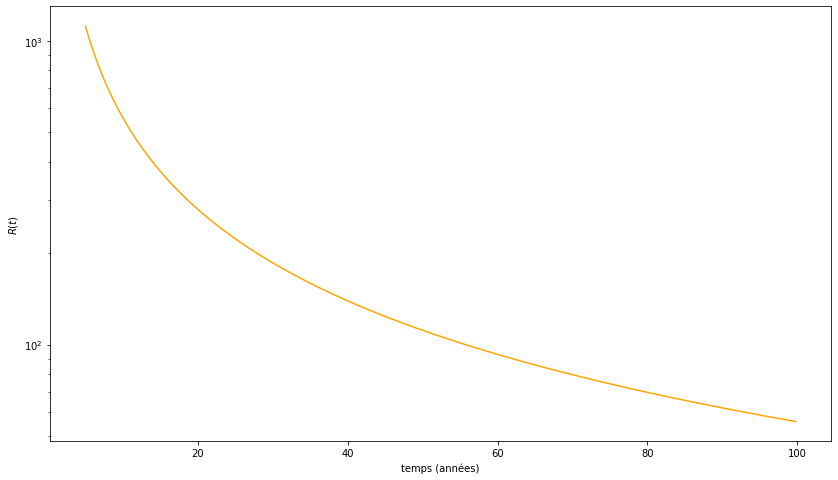

In [19]:
def t_rad(t):
    return t_star**2/t

plt.figure(figsize=[14,8])
plt.yscale('log')

plt.xlabel('temps (années)')
plt.ylabel('$R(t)$')
plt.plot(s2year(t_list2), t_rad(t_list2), color='orange', label='$R(t)$')

In [20]:
def R_restes(t):
    return pow(3/5,1/4)*R_sedov(t_transi)*pow((1+2/3*t/t_transi,1/4)

SyntaxError: unexpected EOF while parsing (<ipython-input-20-a31d05c50e08>, line 2)

In [ ]:
def R_phase2(t):
    if t<=t_transi:
        return R_sedov(t)
    else:
        return R_restes(t)